In [1]:
import pickle
import os
import yaml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from genbench3D.sb_model import LiGAN, ThreeDSBDD, Pocket2Mol, TargetDiff, DiffSBDD, ResGen
from genbench3D.data.source import CrossDocked
from scipy.stats import wilcoxon
from matplotlib.colors import LogNorm
from scipy.stats import false_discovery_control
from scipy.spatial.distance import squareform
from statannotations.Annotator import Annotator

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1
/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe1` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1
/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/rdkit/Chem/MolStandardize/__init__.

In [2]:
config_path = './config/default.yaml'
config = yaml.safe_load(open(config_path, 'r'))

In [3]:
test_crossdocked = CrossDocked(root=config['benchmark_dirpath'],
                                config=config['data'],
                                subset='test')

with open('test_set/ligand_filenames.txt', 'r') as f:
    ligand_filenames = f.readlines()
ligand_filenames = [ligand_filename.strip() for ligand_filename in ligand_filenames]

models = [
            LiGAN(gen_path=config['models']['ligan_gen_dirpath'],
                  minimized_path=config['data']['minimized_path'],
                  ligand_filenames=ligand_filenames),
            ThreeDSBDD(gen_path=config['models']['threedsbdd_gen_dirpath'],
                       minimized_path=config['data']['minimized_path']),
            Pocket2Mol(gen_path=config['models']['pocket2mol_gen_dirpath'],
                       minimized_path=config['data']['minimized_path']),
            TargetDiff(results_path=config['models']['targetdiff_results_filepath'],
                       minimized_path=config['data']['minimized_path']),
            DiffSBDD(gen_path=config['models']['diffsbdd_gen_dirpath'],
                     minimized_path=config['data']['minimized_path']),
            ResGen(gen_path=config['models']['resgen_gen_dirpath'],
                   minimized_path=config['data']['minimized_path'])
            ]

model_names = ['LiGAN', '3D-SBDD', 'Pocket2Mol', 'TargetDiff', 'DiffSBDD', 'ResGen']

results_dirpath = config['results_dir']

In [4]:
model_names

['LiGAN', '3D-SBDD', 'Pocket2Mol', 'TargetDiff', 'DiffSBDD', 'ResGen']

In [23]:
minimizes = [False, True]
d_results = {}
n_res = 0
for ligand_filename in ligand_filenames:
    d_results[ligand_filename] = {}
    for minimize in minimizes:
        d_results[ligand_filename][minimize] = {}
        for model in models:
            target_dirname, real_ligand_filename = ligand_filename.split('/') 
            if minimize:
                results_filename = real_ligand_filename.replace('.sdf', 
                                                            f'_results_{model.name}_minimized.p')
            else:
                results_filename = real_ligand_filename.replace('.sdf', 
                                                            f'_results_{model.name}.p')
            
            results_filepath = os.path.join(results_dirpath, results_filename)

            if os.path.exists(results_filepath):
                with open(results_filepath, 'rb') as f:
                    results = pickle.load(f)
                d_results[ligand_filename][minimize][model.name] = results
                n_res += 1
            else:
                print(results_filepath + ' does not exist')

/home/bb596/hdd/genbench3D/results/2v3r_A_rec_1dy4_snp_lig_tt_docked_1_results_ResGen.p does not exist
/home/bb596/hdd/genbench3D/results/2v3r_A_rec_1dy4_snp_lig_tt_docked_1_results_ResGen_minimized.p does not exist
/home/bb596/hdd/genbench3D/results/2rhy_A_rec_2rhy_mlz_lig_tt_min_0_results_ResGen.p does not exist
/home/bb596/hdd/genbench3D/results/2rhy_A_rec_2rhy_mlz_lig_tt_min_0_results_ResGen_minimized.p does not exist
/home/bb596/hdd/genbench3D/results/2pqw_A_rec_2rhy_mlz_lig_tt_min_0_results_ResGen.p does not exist
/home/bb596/hdd/genbench3D/results/2pqw_A_rec_2rhy_mlz_lig_tt_min_0_results_ResGen_minimized.p does not exist
/home/bb596/hdd/genbench3D/results/3gs6_A_rec_2oxn_oan_lig_tt_docked_4_results_ResGen.p does not exist
/home/bb596/hdd/genbench3D/results/3gs6_A_rec_2oxn_oan_lig_tt_docked_4_results_ResGen_minimized.p does not exist
/home/bb596/hdd/genbench3D/results/1dxo_C_rec_1gg5_e09_lig_tt_min_0_results_ResGen.p does not exist
/home/bb596/hdd/genbench3D/results/1dxo_C_rec_1g

In [24]:
print(n_res)

1142


In [25]:
rows = []
for ligand_filename in ligand_filenames:
    all_model_tested = len(d_results[ligand_filename][False]) == len(models)
    all_mini_model_tested = len(d_results[ligand_filename][True]) == len(models)
    if all_model_tested and all_mini_model_tested:
        for minimize in minimizes:
            for model in models:
                model_results = d_results[ligand_filename][minimize][model.name]
                if minimize:
                    set_names = ['minimized', 'minimized_valid']
                else:
                    set_names = ['raw', 'raw_valid']
                for set_name in set_names:
                    row = {'Model' : model.name,
                          'Relaxed': minimize,
                          'Valid only': 'valid' in set_name,
                          'Ligand filename': ligand_filename}
                    set_results = model_results[set_name]
                    for name, values in set_results.items():
                        # if set_name in ['raw', 'minimized_valid'] and 'Glide' in name:
                        #     values = d_results_glide[ligand_filename][minimize][model.name][set_name][name]
                        
                        if isinstance(values, dict):
                            for k, v in values.items():
                                if (not isinstance(v, list)) and (not isinstance(v, dict)):
                                    row[name+str(k)] = v
                        elif isinstance(values, list):
                            value = np.nanmedian(values)
                            row[name] = value
                        else:
                            value = values
                            row[name] = value
                    rows.append(row)

/tmp/ipykernel_2723631/2644227992.py:28: RuntimeWarning: All-NaN slice encountered
  value = np.nanmedian(values)
/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [26]:
def subset_name(subset):
    if subset:
        return 'Valid relaxed'
    else:
        return 'Raw'

In [27]:
df = pd.DataFrame(rows)

In [28]:
df = df.dropna(how='all', axis=1)

In [29]:
for k in df.keys():
    print(k)

Model
Relaxed
Valid only
Ligand filename
Steric clash
Distance to native centroid
Vina score
Minimized Vina score
Glide score
Minimized Glide score
Gold PLP score
Relative Vina score
Relative Min Vina score
Relative Glide score
Relative Min Glide score
Relative PLP score
Validity2D
Uniqueness2D
Diversity2D
Ring proportion3
Ring proportion5
Ring proportion4
Ring proportion7
Ring proportion6
MW
logP
SAScore
QED
Novelty2D
Maximum training similarity
Validity3D
Strain energy
Number of tested confs
Uniqueness3D
Diversity3D
Novelty3D
Number of valid 3D confs (Validity3D)
Number of invalid bonds (Validity3D)
Number of invalid angles (Validity3D)
Number of invalid torsions (Validity3D)
Number of invalid rings (Validity3D)
Number of new patterns (Validity3D)
Number of new unique patterns (Validity3D)
Min bond q-value (Validity3D)
Geometric mean bond q-value (Validity3D)
Min angle q-value (Validity3D)
Geometric mean angle q-value (Validity3D)
Min torsion q-value (Validity3D)
Geometric mean torsi

In [53]:
df['Model'] = df['Model'].replace('3D_SBDD', '3D-SBDD')
df2 = df[(df['Relaxed'] & df['Valid only']) | (~df['Relaxed'] & ~df['Valid only'])]
df2['Subset'] = df2['Relaxed'] & df2['Valid only']
df2['Subset'] = df2['Subset'].apply(subset_name)

/tmp/ipykernel_2723631/1440390245.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Subset'] = df2['Relaxed'] & df2['Valid only']
/tmp/ipykernel_2723631/1440390245.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Subset'] = df2['Subset'].apply(subset_name)


In [54]:
df2 = df2[['Model', 'Ligand filename', 'Subset', 'Vina score', 
           'Minimized Vina score', 'Glide score', 'Minimized Glide score',
          'Gold PLP score']]

In [55]:
df2

,Model,Ligand filename,Subset,Vina score,Minimized Vina score,Glide score,Minimized Glide score,Gold PLP score
0,LiGAN,BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_d...,Raw,-5.2080,-5.7000,-2.653140,-3.580920,28.37280
2,3D-SBDD,BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_d...,Raw,-6.5545,-6.5670,10000.000000,-4.843860,39.48735
4,Pocket2Mol,BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_d...,Raw,-4.1970,-6.2020,10000.000000,-5.480380,38.63450
6,TargetDiff,BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_d...,Raw,-5.5490,-6.0870,10000.000000,-6.958020,48.45925
8,DiffSBDD,BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_d...,Raw,-4.4565,-5.9360,10000.000000,-4.054705,36.88455
...,...,...,...,...,...,...,...,...
1815,3D-SBDD,DYRK2_HUMAN_145_550_0/4azf_A_rec_5lxc_7aa_lig_...,Valid relaxed,-6.9725,-7.4050,-6.658940,-7.272600,55.27000
1817,Pocket2Mol,DYRK2_HUMAN_145_550_0/4azf_A_rec_5lxc_7aa_lig_...,Valid relaxed,-8.2370,-9.0325,-8.213585,-8.492355,59.08465
1819,TargetDiff,DYRK2_HUMAN_145_550_0/4azf_A_rec_5lxc_7aa_lig_...,Valid relaxed,-6.9230,-7.1630,-6.824150,-7.433210,51.02700
1821,DiffSBDD,DYRK2_HUMAN_145_550_0/4azf_A_rec_5lxc_7aa_lig_...,Valid relaxed,-6.0120,-6.3850,-4.911340,-6.072150,51.79110


In [62]:
df2 = df2.fillna(0)

In [63]:
ligand_counts = df2['Ligand filename'].value_counts()
max_count_ligands = ligand_counts[ligand_counts == ligand_counts.max()].index

In [65]:
df2 = df2[df2['Ligand filename'].isin(max_count_ligands)]

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/algorithms.py:485: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


In [66]:
df2['Model'] = pd.Categorical(df2['Model'], model_names)

In [67]:
df2 = df2.sort_values(['Model', 'Subset', 'Ligand filename'])

In [69]:
len(df2['Ligand filename'].unique())

76

In [70]:
df2['Ligand filename'].unique()

array(['ABL2_HUMAN_274_551_0/4xli_B_rec_4xli_1n1_lig_tt_min_0.sdf',
       'AK1BA_HUMAN_1_316_0/5liu_X_rec_4gq0_qap_lig_tt_min_0.sdf',
       'AKT1_HUMAN_1_137_0/3o96_A_rec_3o96_iqo_lig_tt_docked_2.sdf',
       'AROE_THET8_1_263_0/2cy0_A_rec_2d5c_skm_lig_tt_min_0.sdf',
       'ATS5_HUMAN_262_480_0/3hy9_B_rec_3hyg_099_lig_tt_min_0.sdf',
       'BACE2_HUMAN_76_460_0/4bel_A_rec_2ewy_dbo_lig_tt_min_0.sdf',
       'BAPA_SPHXN_30_402_0/3nfb_A_rec_3nfb_oae_lig_tt_docked_2.sdf',
       'BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_docked_3.sdf',
       'BTRN_BACCI_2_250_0/4m7t_A_rec_4m7t_sam_lig_tt_min_0.sdf',
       'CAT_ECOLX_1_219_0/3u9f_C_rec_3u9f_clm_lig_tt_min_0.sdf',
       'CCPR_YEAST_69_361_0/1a2g_A_rec_4jmv_1ly_lig_tt_min_0.sdf',
       'CD38_HUMAN_44_300_0/3dzh_A_rec_3u4i_cvr_lig_tt_docked_0.sdf',
       'CDK6_HUMAN_1_312_0/2f2c_B_rec_1xo2_fse_lig_tt_min_0.sdf',
       'CHIB_SERMA_1_499_0/1h0i_A_rec_1e6z_ngo_lig_it2_tt_docked_15.sdf',
       'CHIB_SERMA_1_499_0/4z2g_A_rec_4z2g_m6v_l

In [72]:
pairs = []
for i, model_name in enumerate(model_names):
    for model_name2 in model_names[i+1:]:
        pairs.append((model_name, model_name2))

In [73]:
def cap_positive_score(score):
    if score > 0:
        return 0
    else:
        return score

def cap_negative_score(score):
    if score < 0:
        return 0
    else:
        return score

In [74]:
score_colnames = [col for col in df2.columns if ('score' in col) and not ('Relative' in col) and not ('Median' in col)]

for score_colname in score_colnames:
    print(score_colname)
    if ('Vina' in score_colname) or ('Glide' in score_colname):
        df2['Median ' + score_colname] = df2[score_colname].apply(cap_positive_score)
    else:
        df2['Median ' + score_colname] = df2[score_colname].apply(cap_negative_score)

score_colnames = [col for col in df2.columns if ('score' in col) and not ('Relative' in col) and ('Median' in col)]

Vina score
Minimized Vina score
Glide score
Minimized Glide score
Gold PLP score


In [75]:
df2.groupby(['Model', 'Subset']).median()[[colname for colname in df2.columns if 'Median' in colname]]

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/indexes/multi.py:595: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/reshape/util.py:54: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [tile_compat(np.repeat(x, b[i]), np.product(a[i])) for i, x in enumerate(X)]


Median Vina score  Median Minimized Vina score  \
Model      Subset                                                          
LiGAN      Raw                     -5.15100                     -5.66450   
           Valid relaxed           -3.98125                     -4.64025   
3D-SBDD    Raw                     -5.83850                     -5.99475   
           Valid relaxed           -4.85300                     -5.32550   
Pocket2Mol Raw                     -5.13150                     -6.25450   
           Valid relaxed           -5.52750                     -6.28700   
TargetDiff Raw                     -6.13825                     -6.45850   
           Valid relaxed           -5.39350                     -5.93775   
DiffSBDD   Raw                     -4.32400                     -5.45050   
           Valid relaxed           -4.46125                     -5.04425   
ResGen     Raw                     -0.47425                     -4.67775   
           Valid relaxed           -4.16150                     -5.28925   

                          Median Glide score  Median Minimized Glide score  \
Model      Subset                                                            
LiGAN      Raw                     -2.108365                     -3.802895   
           Valid relaxed           -3.473545                     -4.384670   
3D-SBDD    Raw                     -3.366237                     -4.838190   
           Valid relaxed           -4.507580                     -5.211305   
Pocket2Mol Raw                      0.000000                     -5.493932   
           Valid relaxed           -5.300695                     -5.936113   
TargetDiff Raw                      0.000000                     -5.821705   
           Valid relaxed           -5.462045                     -6.383727   
DiffSBDD   Raw                      0.000000                     -4.454960   
           Valid relaxed           -3.193520                     -4.980218   
ResGen     Raw                      0.000000                     -4.671463   
           Valid relaxed           -3.464487                     -4.961168   

                          Median Gold PLP score  
Model      Subset                                
LiGAN      Raw                        25.627400  
           Valid relaxed              26.383325  
3D-SBDD    Raw                        34.334850  
           Valid relaxed              37.820750  
Pocket2Mol Raw                        37.692025  
           Valid relaxed              39.395625  
TargetDiff Raw                        45.394800  
           Valid relaxed              48.014425  
DiffSBDD   Raw                        26.977275  
           Valid relaxed              37.987900  
ResGen     Raw                        19.078675  
           Valid relaxed              32.629975

In [76]:
df2

,Model,Ligand filename,Subset,Vina score,Minimized Vina score,Glide score,Minimized Glide score,Gold PLP score,Median Vina score,Median Minimized Vina score,Median Glide score,Median Minimized Glide score,Median Gold PLP score
1464,LiGAN,ABL2_HUMAN_274_551_0/4xli_B_rec_4xli_1n1_lig_t...,Raw,-4.9470,-5.3950,-2.619550,-4.003420,23.77235,-4.9470,-5.3950,-2.619550,-4.003420,23.77235
1488,LiGAN,AK1BA_HUMAN_1_316_0/5liu_X_rec_4gq0_qap_lig_tt...,Raw,-6.1830,-6.6940,-2.746050,-4.765675,38.87470,-6.1830,-6.6940,-2.746050,-4.765675,38.87470
1512,LiGAN,AKT1_HUMAN_1_137_0/3o96_A_rec_3o96_iqo_lig_tt_...,Raw,-6.0075,-6.5580,-3.513120,-4.214770,26.22060,-6.0075,-6.5580,-3.513120,-4.214770,26.22060
1224,LiGAN,AROE_THET8_1_263_0/2cy0_A_rec_2d5c_skm_lig_tt_...,Raw,-4.7190,-5.2710,-2.387580,-3.531300,18.13190,-4.7190,-5.2710,-2.387580,-3.531300,18.13190
1536,LiGAN,ATS5_HUMAN_262_480_0/3hy9_B_rec_3hyg_099_lig_t...,Raw,-5.6300,-5.9670,-2.577920,-3.795840,32.68070,-5.6300,-5.9670,-2.577920,-3.795840,32.68070
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1415,ResGen,TNKS2_HUMAN_948_1162_0/5aeh_A_rec_5aeh_8ir_lig...,Valid relaxed,-5.2120,-6.3640,-5.041180,-6.525020,32.37230,-5.2120,-6.3640,-5.041180,-6.525020,32.37230
815,ResGen,UBE2T_HUMAN_1_156_0/5ngz_A_rec_5ngz_2bg_lig_tt...,Valid relaxed,-3.5130,-4.0725,-4.911995,-5.127095,32.58470,-3.5130,-4.0725,-4.911995,-5.127095,32.58470
1439,ResGen,UPPS_ECOLI_1_253_0/4h3c_A_rec_5cqj_53q_lig_tt_...,Valid relaxed,-4.8310,-5.7430,-4.849240,-5.470180,25.50070,-4.8310,-5.7430,-4.849240,-5.470180,25.50070
839,ResGen,VAOX_PENSI_1_560_0/1e8h_A_rec_1e8h_adp_lig_tt_...,Valid relaxed,-5.9730,-6.5250,-5.513695,-6.050795,49.06050,-5.9730,-6.5250,-5.513695,-6.050795,49.06050


In [77]:
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import PathPatch
pastel_palette = sns.color_palette("pastel")
colorblind_palette = sns.color_palette("colorblind")

In [78]:
colorblind_palette

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [79]:
pastel_palette

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [80]:
sns.set_context('talk')

Median Vina score


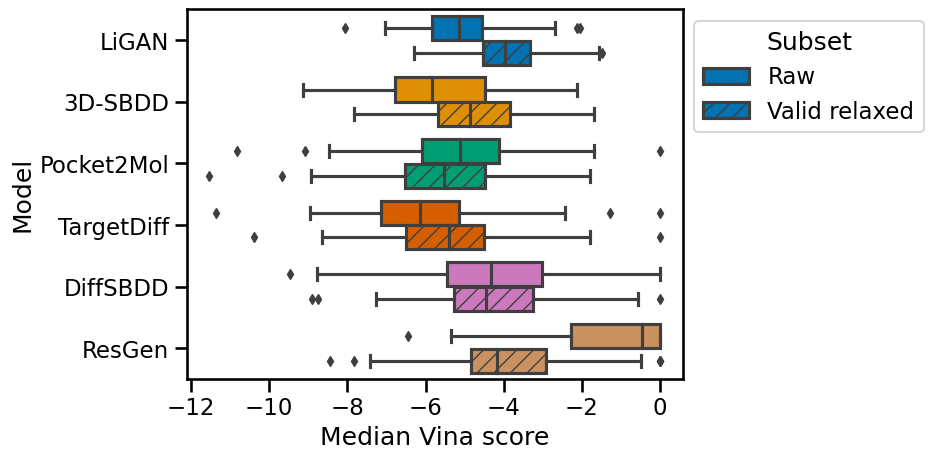

Median Minimized Vina score


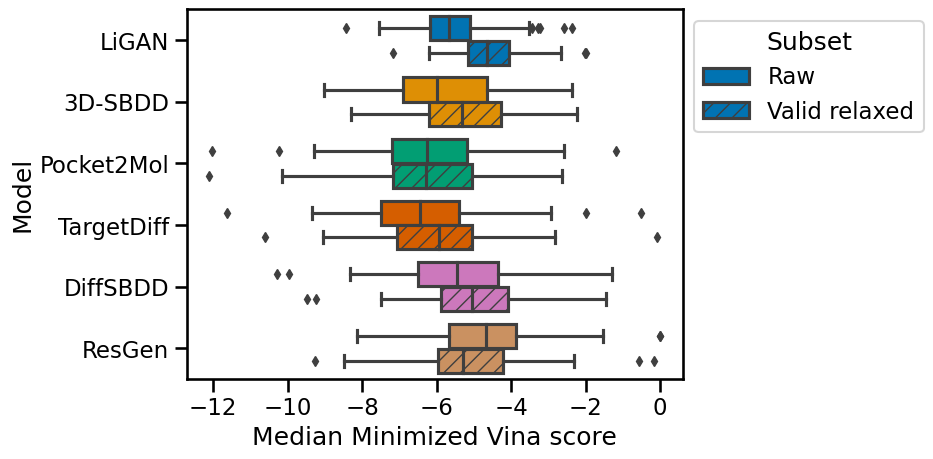

Median Glide score


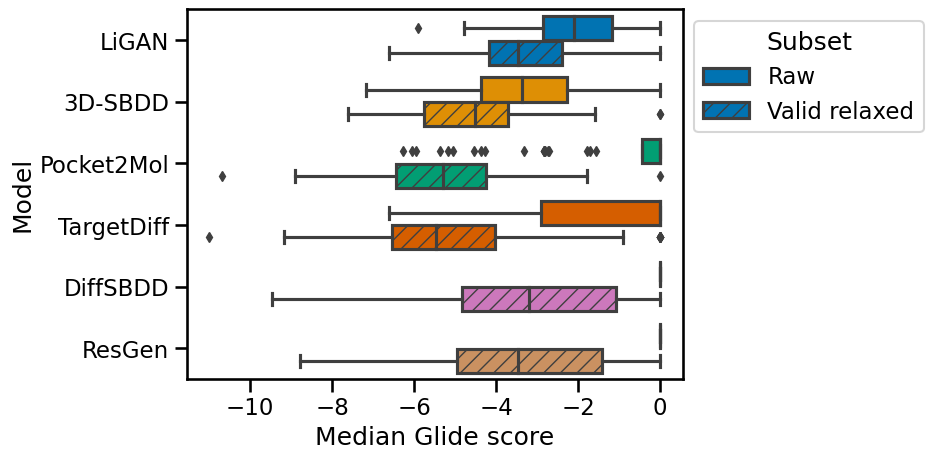

Median Minimized Glide score


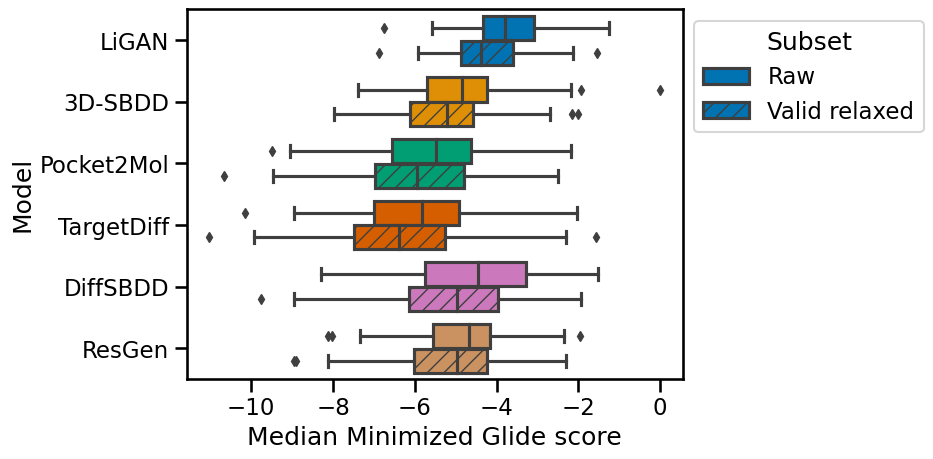

Median Gold PLP score


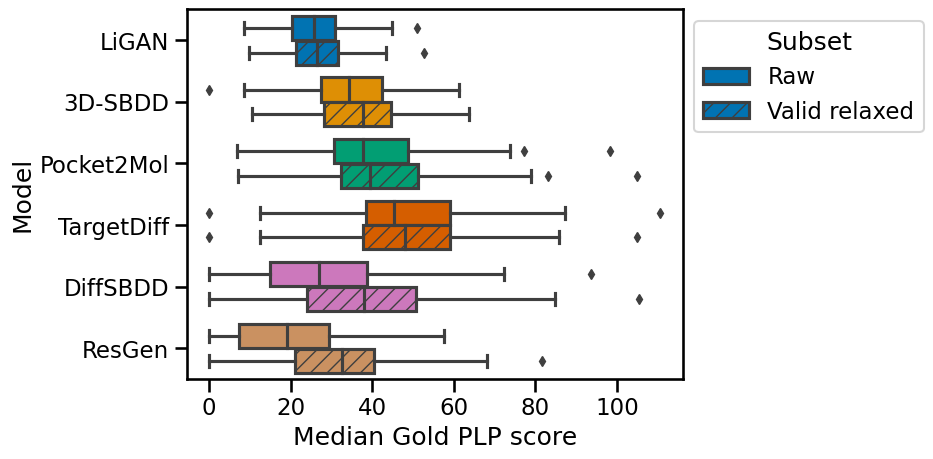

In [81]:
subsets = df2['Subset'].unique()
removed_models = ['DiffSBDD', 'ResGen']
for score_colname in score_colnames:
    print(score_colname)

    pairs = []
    for model_name in model_names:
        pairs.append(((model_name, subsets[0]), (model_name, subsets[1])))
    
    plotting_parameters = {
        'data':    df2,
        'y':       'Model',
        'x':       score_colname,
        'hue':     'Subset'
    }
    # plt.figure(figsize=(9, 5))
    ax = sns.boxplot(**plotting_parameters)

    box_patches = [patch for patch in ax.patches if isinstance(patch, PathPatch)]
    for i, patch in enumerate(box_patches):
        if i % 2 == 0:
            # pal = pastel_palette
            patch.set_hatch('')
        else:
            # pal = colorblind_palette
            patch.set_hatch('//')
        # color = pal[i // 2]
        color = colorblind_palette[i // 2]
        patch.set_facecolor(color)
        # patch.set_edgecolor('black')
        
        
    handles = [tuple(box_patches[::2]), tuple(box_patches[1::2])]
    labels = ['Raw', 'Valid relaxed']
    title = 'Subset'
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.legend(handles=[box_patches[0], box_patches[1]], 
              labels=labels,
              loc="upper left", bbox_to_anchor=(1.0, 1.0), title='Subset')
    # ax.legend(handles=handles,
    #           labels=labels,
    #           title=title,
    #           handlelength=5, handler_map={tuple: HandlerTuple(ndivide=None, pad=0.1)},
    #           loc="upper left", 
    #           bbox_to_anchor=(1, 1))
    
    
    plt.savefig(f'figures/{score_colname}_stats.png', dpi=300, bbox_inches='tight')
    # ax.patches[1].set_facecolor(pastel_palette[0])
    plt.show()

In [46]:
subsets = df2['Subset'].unique()
n_models = len(model_names)
rows = []
adjusted_p_values = []
for subset in subsets:
    for score_colname in score_colnames: 
        # p_values = np.ones((n_models, n_models))
        score_p_values = []
        for i, model_name in enumerate(model_names):
            for j, model_name2 in enumerate(model_names[i+1:]):
                j = j + i + 1
                
                values1 = df2[(df2['Model'] == model_name) & (df2['Subset'] == subset)][score_colname].values
                values2 = df2[(df2['Model'] == model_name2) & (df2['Subset'] == subset)][score_colname].values
                median1 = np.nanmedian(values1)
                median2 = np.nanmedian(values2)
                difference = values1 - values2
                median_difference = np.nanmedian(difference)
                if not ((score_colname == 'Median Glide score') and (model_name == 'DiffSBDD' and model_name2 == 'ResGen') and (subset == 'Raw')):
                    wilcoxon_result = wilcoxon(difference, alternative="two-sided", method='approx')
                    p_value = wilcoxon_result.pvalue
                    effect_size = wilcoxon_result.zstatistic / np.sqrt(len(values1) + len(values2))
                # else:
                #     p_value = np.nan
                #     effect_size = np.nan
                else:
                    p_value = 1.0
                    effect_size = 0.0

                row = {'Subset': subset,
                           'Scoring function': score_colname,
                            'Model 1': model_name,
                          'Model 2' : model_name2,
                          'Median difference': median_difference,
                          'Effect size': effect_size}
                rows.append(row)
                score_p_values.append(p_value)

        adjusted_p_values.extend(false_discovery_control(score_p_values))

for row, p_value in zip(rows, adjusted_p_values):
    row['p-value'] = p_value

stats_df = pd.DataFrame(rows)
# stats_df['Effect size'] = stats_df['Effect size'].round(2)
stats_df.to_csv('between_models_scores_stats.csv')

In [47]:
n_models = len(model_names)
rows = []
adjusted_p_values = []
for score_colname in score_colnames: 
    score_p_values = []
    for i, model_name in enumerate(model_names):
        values1 = df2[(df2['Model'] == model_name) & (df2['Subset'] == subsets[0])][score_colname].values
        values2 = df2[(df2['Model'] == model_name) & (df2['Subset'] == subsets[1])][score_colname].values
        median1 = np.nanmedian(values1)
        median2 = np.nanmedian(values2)
        difference = values1 - values2
        median_difference = np.nanmedian(difference)
        wilcoxon_result = wilcoxon(difference, alternative="two-sided", method='approx')
        p_value = wilcoxon_result.pvalue
        effect_size = wilcoxon_result.zstatistic / np.sqrt(len(values1) + len(values2))
    # else:
    #     p_value = np.nan
    #     effect_size = np.nan
        row = {
            'Model 1': model_name,
            'Scoring function': score_colname,
            'Subset 1': subsets[0],
            'Subset 2': subsets[1],
              'Median difference': median_difference,
              'Effect size': effect_size}
        rows.append(row)
        score_p_values.append(p_value)

    adjusted_p_values.extend(false_discovery_control(score_p_values))

for row, p_value in zip(rows, adjusted_p_values):
    row['p-value'] = p_value

stats_df = pd.DataFrame(rows)
# stats_df['effect_size'] = stats_df['effect_size'].round(2)
stats_df.to_csv('between_subsets_scores_stats.csv')

In [49]:
score_rows = []
for ligand_filename in test_crossdocked.get_ligand_filenames():
    all_model_tested = len(d_results[ligand_filename][False]) == len(models)
    all_mini_model_tested = len(d_results[ligand_filename][True]) == len(models)
    if all_model_tested and all_mini_model_tested:
        for minimize in minimizes:
            for model in models:
                model_results = d_results[ligand_filename][minimize][model.name]
                if minimize:
                    set_names = ['minimized', 'minimized_valid']
                else:
                    set_names = ['raw', 'raw_valid']
                for set_name in set_names:
                    set_results = model_results[set_name]
                    for name, values in set_results.items():
                        if set_name in ['raw', 'minimized_valid'] and 'Glide' in name:
                            values = d_results_glide[ligand_filename][minimize][model.name][set_name][name]
                        if 'score' in name:
                            assert isinstance(values, list)
                            for value in values:
                                row = {'Model' : model.name,
                                      'Relaxed': minimize,
                                      'Valid only': 'valid' in set_name,
                                      'Ligand filename': ligand_filename,
                                      'Name': name,
                                      'Value': value}
                                score_rows.append(row)

In [50]:
score_df = pd.DataFrame(score_rows)
score_df = score_df.dropna()

In [51]:
score_df['Model'] = score_df['Model'].replace('3D_SBDD', '3D-SBDD')
score_df2 = score_df[(score_df['Relaxed'] & score_df['Valid only']) | (~score_df['Relaxed'] & ~score_df['Valid only'])]
score_df2['Subset'] = score_df2['Relaxed'] & score_df2['Valid only']
score_df2['Subset'] = score_df2['Subset'].apply(subset_name)

/tmp/ipykernel_844743/251537823.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df2['Subset'] = score_df2['Relaxed'] & score_df2['Valid only']
/tmp/ipykernel_844743/251537823.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df2['Subset'] = score_df2['Subset'].apply(subset_name)


In [52]:
def get_better_score(row):
    if 'PLP' in row['Name']:
        return row['Value'] > 0
    else:
        return row['Value'] < 0

In [53]:
relative_score_df = score_df2[score_df2['Name'].str.contains('Relative')]

In [54]:
relative_score_df['Better than native'] = relative_score_df.apply(get_better_score, axis=1)

/tmp/ipykernel_844743/833521583.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relative_score_df['Better than native'] = relative_score_df.apply(get_better_score, axis=1)


In [55]:
relative_score_df['Name'] = relative_score_df['Name'].replace('Relative PLP score', 'Relative Gold PLP score')

/tmp/ipykernel_844743/2984775006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relative_score_df['Name'] = relative_score_df['Name'].replace('Relative PLP score', 'Relative Gold PLP score')


In [56]:
relative_score_df[relative_score_df['Name'] == 'Relative Glide score']

,Model,Relaxed,Valid only,Ligand filename,Name,Value,Subset,Better than native
539,LiGAN,False,False,BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_d...,Relative Glide score,10005.821060,Raw,False
540,LiGAN,False,False,BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_d...,Relative Glide score,6.233483,Raw,False
541,LiGAN,False,False,BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_d...,Relative Glide score,0.479590,Raw,False
542,LiGAN,False,False,BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_d...,Relative Glide score,10005.821060,Raw,False
543,LiGAN,False,False,BSD_ASPTE_1_130_0/2z3h_A_rec_1wn6_bst_lig_tt_d...,Relative Glide score,0.644190,Raw,False
...,...,...,...,...,...,...,...,...
1035115,ResGen,True,True,DYRK2_HUMAN_145_550_0/4azf_A_rec_5lxc_7aa_lig_...,Relative Glide score,-1.810270,Valid relaxed,True
1035116,ResGen,True,True,DYRK2_HUMAN_145_550_0/4azf_A_rec_5lxc_7aa_lig_...,Relative Glide score,-0.398420,Valid relaxed,True
1035117,ResGen,True,True,DYRK2_HUMAN_145_550_0/4azf_A_rec_5lxc_7aa_lig_...,Relative Glide score,2.540040,Valid relaxed,False
1035118,ResGen,True,True,DYRK2_HUMAN_145_550_0/4azf_A_rec_5lxc_7aa_lig_...,Relative Glide score,0.075360,Valid relaxed,False


In [57]:
grouped_score_df = relative_score_df.pivot_table(index=['Model', 'Subset', 'Ligand filename'], 
                                                 columns='Name',
                                                 values='Better than native',
                                                 aggfunc='mean')
grouped_score_df = grouped_score_df.reset_index()
grouped_score_df['Model'] = pd.Categorical(grouped_score_df['Model'], model_names)
grouped_score_df = grouped_score_df.sort_values(['Model', 'Subset', 'Ligand filename'])

In [58]:
grouped_score_df = grouped_score_df.dropna()
ligand_counts = grouped_score_df['Ligand filename'].value_counts()
max_count_ligands = ligand_counts[ligand_counts == ligand_counts.max()].index
grouped_score_df = grouped_score_df[grouped_score_df['Ligand filename'].isin(max_count_ligands)]

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/algorithms.py:485: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


In [59]:
relative_score_df.pivot_table(index=['Model', 'Subset'], 
                                                 columns='Name',
                                                 values='Better than native',
                                                 aggfunc='mean')

Name                      Relative Glide score  Relative Gold PLP score  \
Model      Subset                                                         
3D-SBDD    Raw                        0.304388                 0.156760   
           Valid relaxed              0.268184                 0.216314   
DiffSBDD   Raw                        0.045846                 0.108898   
           Valid relaxed              0.125133                 0.201332   
LiGAN      Raw                        0.216411                 0.092938   
           Valid relaxed              0.125482                 0.099234   
Pocket2Mol Raw                        0.178013                 0.146722   
           Valid relaxed              0.328215                 0.245361   
ResGen     Raw                        0.031667                 0.027953   
           Valid relaxed              0.187826                 0.109281   
TargetDiff Raw                        0.203241                 0.331938   
           Valid relaxed              0.312979                 0.386250   

Name                      Relative Min Glide score  Relative Min Vina score  \
Model      Subset                                                             
3D-SBDD    Raw                            0.300951                 0.297668   
           Valid relaxed                  0.268182                 0.256299   
DiffSBDD   Raw                            0.192735                 0.234227   
           Valid relaxed                  0.183303                 0.199625   
LiGAN      Raw                            0.140657                 0.247519   
           Valid relaxed                  0.128607                 0.138686   
Pocket2Mol Raw                            0.363435                 0.323279   
           Valid relaxed                  0.317784                 0.385135   
ResGen     Raw                            0.267734                 0.135890   
           Valid relaxed                  0.235771                 0.208317   
TargetDiff Raw                            0.401431                 0.382870   
           Valid relaxed                  0.366446                 0.364307   

Name                      Relative Vina score  
Model      Subset                              
3D-SBDD    Raw                       0.268519  
           Valid relaxed             0.247391  
DiffSBDD   Raw                       0.117663  
           Valid relaxed             0.151994  
LiGAN      Raw                       0.195884  
           Valid relaxed             0.118179  
Pocket2Mol Raw                       0.171352  
           Valid relaxed             0.357494  
ResGen     Raw                       0.019178  
           Valid relaxed             0.126758  
TargetDiff Raw                       0.318827  
           Valid relaxed             0.365487

In [60]:
grouped_score_df.groupby(['Model', 'Subset']).median()[['Relative Vina score',
                                                       'Relative Min Vina score',
                                                       'Relative Glide score',
                                                       'Relative Min Glide score',
                                                       'Relative Gold PLP score']]

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/indexes/multi.py:595: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/reshape/util.py:54: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [tile_compat(np.repeat(x, b[i]), np.product(a[i])) for i, x in enumerate(X)]


Name                      Relative Vina score  Relative Min Vina score  \
Model      Subset                                                        
LiGAN      Raw                       0.080913                 0.146863   
           Valid relaxed             0.025658                 0.037868   
3D-SBDD    Raw                       0.174917                 0.248596   
           Valid relaxed             0.126786                 0.159615   
Pocket2Mol Raw                       0.074093                 0.229583   
           Valid relaxed             0.307487                 0.352045   
TargetDiff Raw                       0.207955                 0.309477   
           Valid relaxed             0.225679                 0.255000   
DiffSBDD   Raw                       0.035000                 0.165000   
           Valid relaxed             0.074773                 0.111111   
ResGen     Raw                       0.000000                 0.040000   
           Valid relaxed             0.038405                 0.109524   

Name                      Relative Glide score  Relative Min Glide score  \
Model      Subset                                                          
LiGAN      Raw                        0.052343                  0.031258   
           Valid relaxed              0.000000                  0.000000   
3D-SBDD    Raw                        0.206383                  0.145914   
           Valid relaxed              0.116780                  0.095489   
Pocket2Mol Raw                        0.116111                  0.285783   
           Valid relaxed              0.179825                  0.188562   
TargetDiff Raw                        0.152112                  0.385565   
           Valid relaxed              0.176945                  0.250156   
DiffSBDD   Raw                        0.010000                  0.054300   
           Valid relaxed              0.029042                  0.042059   
ResGen     Raw                        0.000000                  0.125850   
           Valid relaxed              0.025278                  0.039947   

Name                      Relative Gold PLP score  
Model      Subset                                  
LiGAN      Raw                           0.013794  
           Valid relaxed                 0.010000  
3D-SBDD    Raw                           0.097575  
           Valid relaxed                 0.144787  
Pocket2Mol Raw                           0.068323  
           Valid relaxed                 0.121321  
TargetDiff Raw                           0.279722  
           Valid relaxed                 0.261634  
DiffSBDD   Raw                           0.035625  
           Valid relaxed                 0.123904  
ResGen     Raw                           0.000000  
           Valid relaxed                 0.018812

In [61]:
score_colnames = [colname for colname in grouped_score_df.columns if 'score' in colname]

Relative Glide score


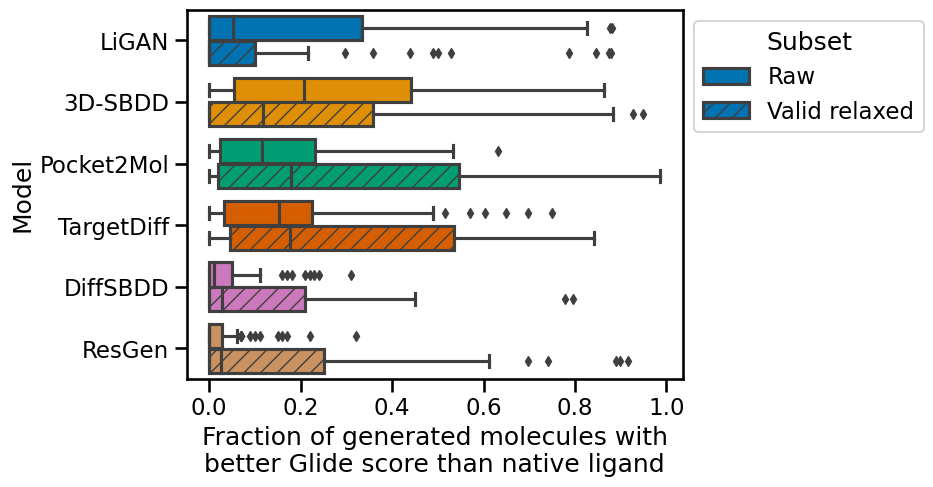

Relative Gold PLP score


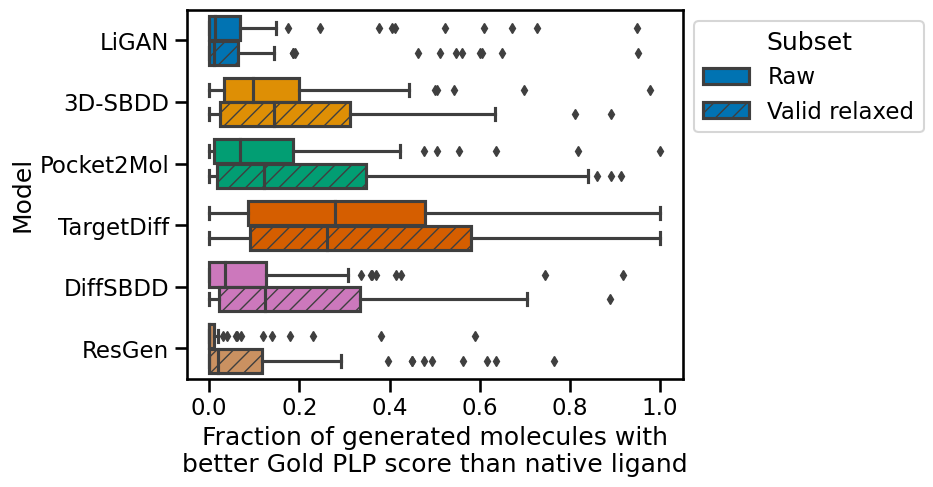

Relative Min Glide score


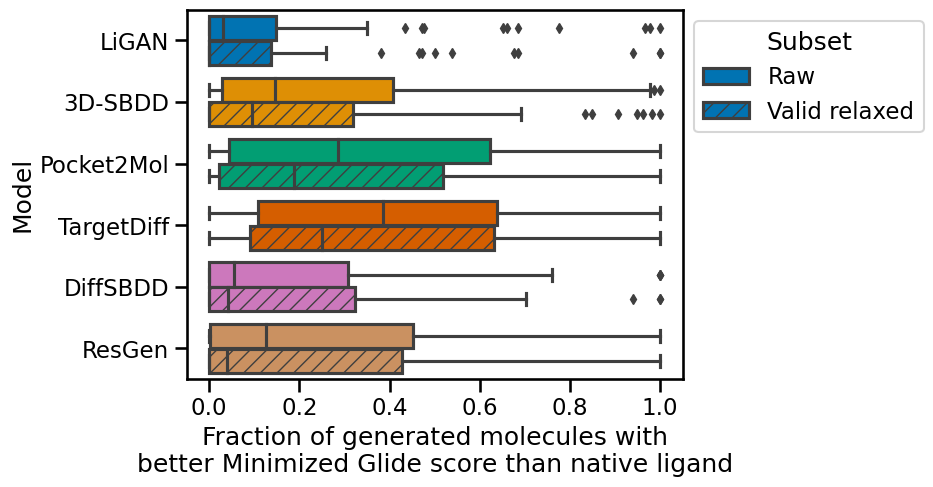

Relative Min Vina score


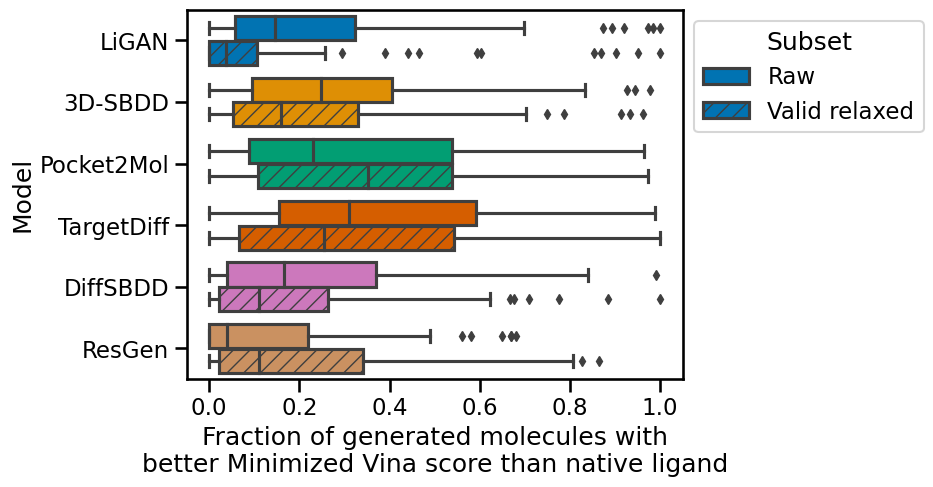

Relative Vina score


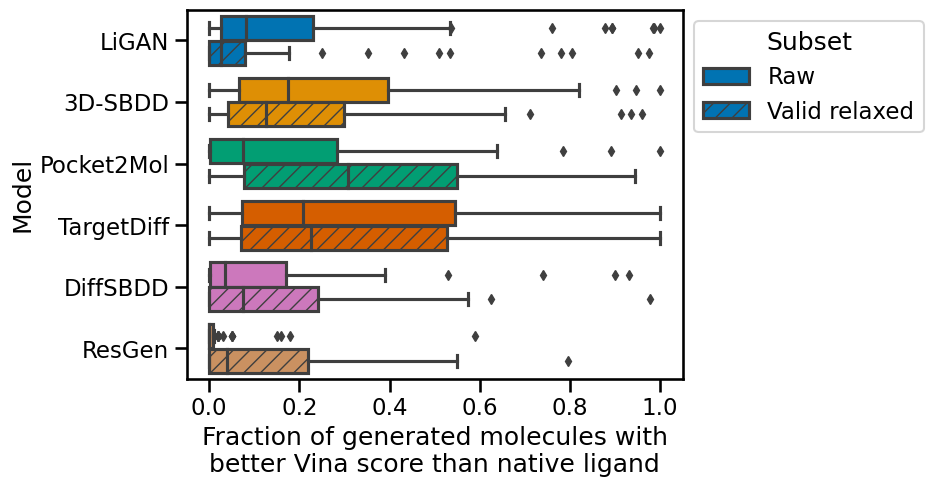

In [62]:
subsets = grouped_score_df['Subset'].unique()
for score_colname in score_colnames:
    print(score_colname)

    pairs = []
    for model_name in model_names:
        pairs.append(((model_name, subsets[0]), (model_name, subsets[1])))
    
    plotting_parameters = {
        'data':    grouped_score_df,
        'y':       'Model',
        'x':       score_colname,
        'hue':     'Subset'
    }
    # plt.figure(figsize=(9, 5))
    ax = sns.boxplot(**plotting_parameters)    

    box_patches = [patch for patch in ax.patches if isinstance(patch, PathPatch)]
    for i, patch in enumerate(box_patches):
        if i % 2 == 0:
            # pal = pastel_palette
            patch.set_hatch('')
        else:
            # pal = colorblind_palette
            patch.set_hatch('//')
        # color = pal[i // 2]
        color = colorblind_palette[i // 2]
        patch.set_facecolor(color)
        # patch.set_edgecolor('black')
        
        
    handles = [tuple(box_patches[::2]), tuple(box_patches[1::2])]
    labels = ['Raw', 'Valid relaxed']
    title = 'Subset'
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.legend(handles=[box_patches[0], box_patches[1]], 
              labels=labels,
              loc="upper left", bbox_to_anchor=(1.0, 1.0), title='Subset')
    
    plt.xlabel(f'Fraction of generated molecules with\nbetter {score_colname.split("Relative ")[-1].replace("Min", "Minimized")} than native ligand')

    plt.savefig(f'figures/better_{score_colname}_stats.png', dpi=300, bbox_inches='tight')
    plt.show()

In [63]:
subsets = grouped_score_df['Subset'].unique()
n_models = len(model_names)
rows = []
adjusted_p_values = []
for subset in subsets:
    for score_colname in score_colnames: 
        # p_values = np.ones((n_models, n_models))
        score_p_values = []
        for i, model_name in enumerate(model_names):
            for j, model_name2 in enumerate(model_names[i+1:]):
                j = j + i + 1
                
                values1 = grouped_score_df[(grouped_score_df['Model'] == model_name) & (grouped_score_df['Subset'] == subset)][score_colname].values
                values2 = grouped_score_df[(grouped_score_df['Model'] == model_name2) & (grouped_score_df['Subset'] == subset)][score_colname].values
                median1 = np.nanmedian(values1)
                median2 = np.nanmedian(values2)
                difference = values1 - values2
                median_difference = np.nanmedian(difference)
                if not ((score_colname == 'Median Glide score') and (model_name == 'DiffSBDD' and model_name2 == 'ResGen') and (subset == 'Raw')):
                    wilcoxon_result = wilcoxon(difference, alternative="two-sided", method='approx')
                    p_value = wilcoxon_result.pvalue
                    effect_size = wilcoxon_result.zstatistic / np.sqrt(len(values1) + len(values2))
                # else:
                #     p_value = np.nan
                #     effect_size = np.nan
                else:
                    p_value = 1.0
                    effect_size = 0.0

                row = {'Subset': subset,
                           'Scoring function': score_colname,
                            'Model 1': model_name,
                          'Model 2' : model_name2,
                          'Median difference': median_difference,
                          'Effect size': effect_size}
                rows.append(row)
                score_p_values.append(p_value)

        adjusted_p_values.extend(false_discovery_control(score_p_values))

for row, p_value in zip(rows, adjusted_p_values):
    row['p-value'] = p_value

stats_df = pd.DataFrame(rows)
# stats_df['Effect size'] = stats_df['Effect size'].round(2)
stats_df.to_csv('between_models_relative_stats.csv')

In [64]:
n_models = len(model_names)
rows = []
adjusted_p_values = []
for score_colname in score_colnames: 
    score_p_values = []
    for i, model_name in enumerate(model_names):
        values1 = grouped_score_df[(grouped_score_df['Model'] == model_name) & (grouped_score_df['Subset'] == subsets[0])][score_colname].values
        values2 = grouped_score_df[(grouped_score_df['Model'] == model_name) & (grouped_score_df['Subset'] == subsets[1])][score_colname].values
        median1 = np.nanmedian(values1)
        median2 = np.nanmedian(values2)
        difference = values1 - values2
        median_difference = np.nanmedian(difference)
        wilcoxon_result = wilcoxon(difference, alternative="two-sided", method='approx', correction=True)
        p_value = wilcoxon_result.pvalue
        effect_size = wilcoxon_result.zstatistic / np.sqrt(len(values1) + len(values2))

        # if median_difference > 0.08:
        #     import pdb;pdb.set_trace()
    # else:
    #     p_value = np.nan
    #     effect_size = np.nan
        row = {
            'Model 1': model_name,
            'Scoring function': score_colname,
            'Subset 1': subsets[0],
            'Subset 2': subsets[1],
              'Median difference': median_difference,
              'Effect size': effect_size}
        rows.append(row)
        score_p_values.append(p_value)

    adjusted_p_values.extend(false_discovery_control(score_p_values))

for row, p_value in zip(rows, adjusted_p_values):
    row['p-value'] = p_value

stats_df = pd.DataFrame(rows)
# stats_df['effect_size'] = stats_df['effect_size'].round(2)
stats_df.to_csv('between_subsets_relative_stats.csv')

In [86]:
difference

array([-0.26666667, -0.02247191,  0.        ,  0.        , -0.01052632,
       -0.05952381,  0.        , -0.01098901, -0.10764706, -0.0875    ,
       -0.01176471, -0.32142857,  0.        , -0.0952381 , -0.04938272,
       -0.13402062, -0.37696629, -0.02469136, -0.14285714])

In [87]:
wilcoxon_result

WilcoxonResult(statistic=0.0, pvalue=0.0007265138800579511)

In [88]:
wilcoxon_result.zstatistic

-3.3793729137700357

In [89]:
wilcoxon_result.zstatistic

-3.3793729137700357

In [90]:
score_rows = []
for ligand_filename in test_crossdocked.get_ligand_filenames():
    all_model_tested = len(d_results[ligand_filename][False]) == len(models)
    all_mini_model_tested = len(d_results[ligand_filename][True]) == len(models)
    if all_model_tested and all_mini_model_tested:
        for minimize in minimizes:
            for model in models:
                model_results = d_results[ligand_filename][minimize][model.name]
                if minimize:
                    set_names = ['minimized', 'minimized_valid']
                else:
                    set_names = ['raw', 'raw_valid']
                for set_name in set_names:
                    set_results = model_results[set_name]
                    
                    target_dirname, real_ligand_filename = ligand_filename.split('/') 
                    if minimize:
                        results_filename = real_ligand_filename.replace('.sdf', 
                                                                    f'_results_{model.name}_minimized_sc.p')
                    else:
                        results_filename = real_ligand_filename.replace('.sdf', 
                                                                    f'_results_{model.name}_sc.p')
                    results_filepath = os.path.join(results_dirpath, results_filename)
                    with open(results_filepath, 'rb') as f:
                        sc_results = pickle.load(f)
                    sc_set_results = sc_results[set_name]

                    if 'Vina score' in set_results and 'Steric clash' in sc_set_results:
                        if len(set_results['Vina score']) == len(sc_set_results['Steric clash']):
                            for i, (vina_score, n_clash) in enumerate(zip(set_results['Vina score'], sc_set_results['Steric clash'])):
                                row = {'Model' : model.name,
                                      'Relaxed': minimize,
                                      'Valid only': 'valid' in set_name,
                                      'Ligand filename': ligand_filename,
                                      'Vina score' : vina_score,
                                      'Number of clashes': n_clash,
                                      'Index': i,
                                      'Total': len(set_results['Vina score'])}
                                score_rows.append(row)

In [91]:
sc_df = pd.DataFrame(score_rows)

In [92]:
sc_df[(sc_df['Number of clashes'] == 0) & (sc_df['Vina score'] > 250)]

,Model,Relaxed,Valid only,Ligand filename,Vina score,Number of clashes,Index,Total
23812,DiffSBDD,False,False,PPIA_HUMAN_1_165_0/2rma_A_rec_3rdd_ea4_lig_tt_...,275.214,0,50,100
23844,DiffSBDD,False,False,PPIA_HUMAN_1_165_0/2rma_A_rec_3rdd_ea4_lig_tt_...,273.786,0,82,100
23855,DiffSBDD,False,False,PPIA_HUMAN_1_165_0/2rma_A_rec_3rdd_ea4_lig_tt_...,308.855,0,93,100
24350,DiffSBDD,True,False,PPIA_HUMAN_1_165_0/2rma_A_rec_3rdd_ea4_lig_tt_...,251.267,0,50,99
24392,DiffSBDD,True,False,PPIA_HUMAN_1_165_0/2rma_A_rec_3rdd_ea4_lig_tt_...,282.940,0,92,99
41970,DiffSBDD,False,False,NOS3_HUMAN_65_480_0/1rs9_A_rec_1dmk_itu_lig_tt...,290.917,0,99,100
42527,DiffSBDD,True,False,NOS3_HUMAN_65_480_0/1rs9_A_rec_1dmk_itu_lig_tt...,267.150,0,99,100
47986,DiffSBDD,False,False,POL_FOAMV_861_1060_0/5mma_A_rec_4ztf_x2p_lig_t...,309.367,0,3,100
48477,DiffSBDD,True,False,POL_FOAMV_861_1060_0/5mma_A_rec_4ztf_x2p_lig_t...,293.737,0,3,100
52423,DiffSBDD,False,False,PYRE_BACAN_1_210_0/4rv4_A_rec_4rv4_prp_lig_tt_...,269.220,0,9,100


In [93]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

In [169]:
sns.set_context('talk')

0.11


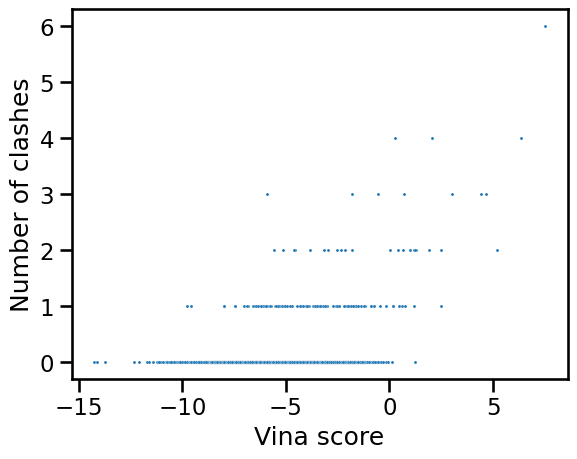

0.09


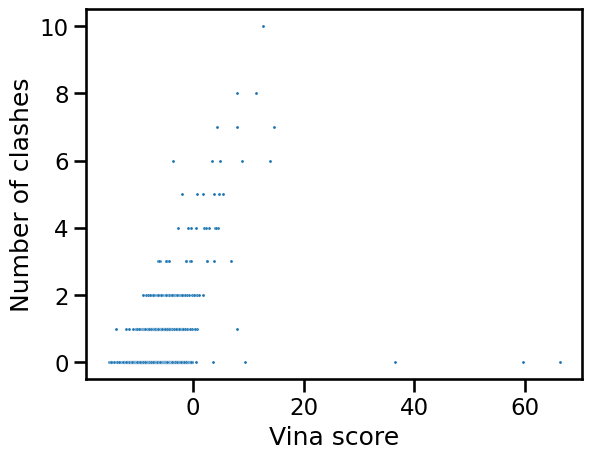

0.21


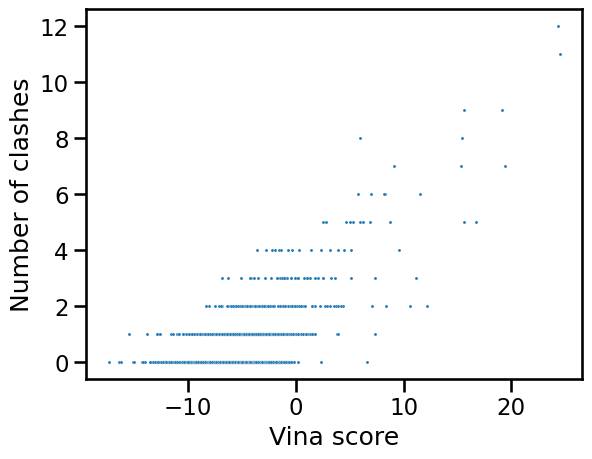

0.3


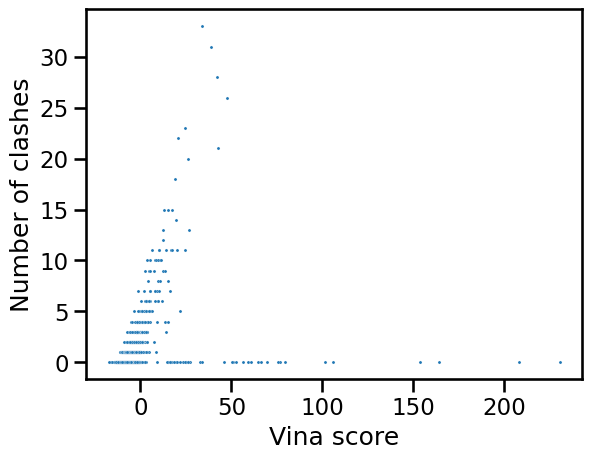

0.31


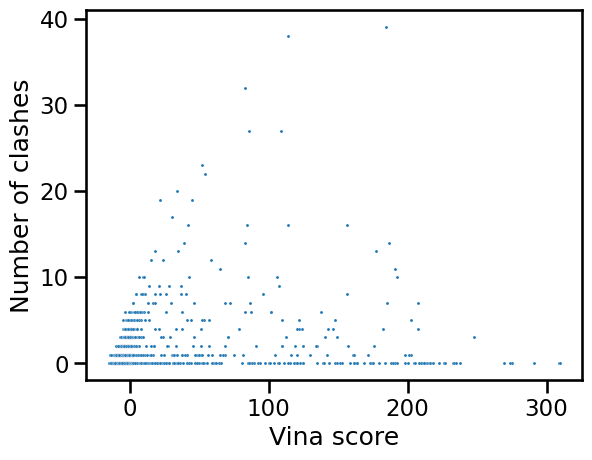

0.85


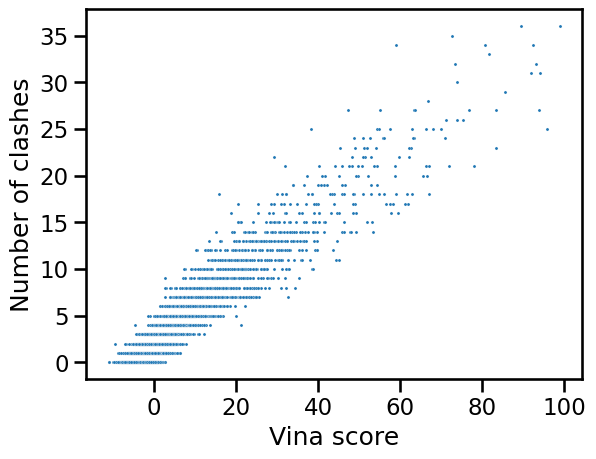

In [170]:
for model_name in model_names:
    subset_df = sc_df[(~sc_df['Relaxed']) & (~sc_df['Valid only']) & (sc_df['Model'] == model_name)]
    coeff = spearmanr(subset_df['Vina score'], subset_df['Number of clashes']).statistic
    sns.scatterplot(data=subset_df,
               x='Vina score',
               y='Number of clashes',
               s=5)
    print(np.around(coeff, 2))
    plt.savefig(f'figures/{model_name}_vs_clash.png', dpi=300, bbox_inches='tight')
    plt.show()

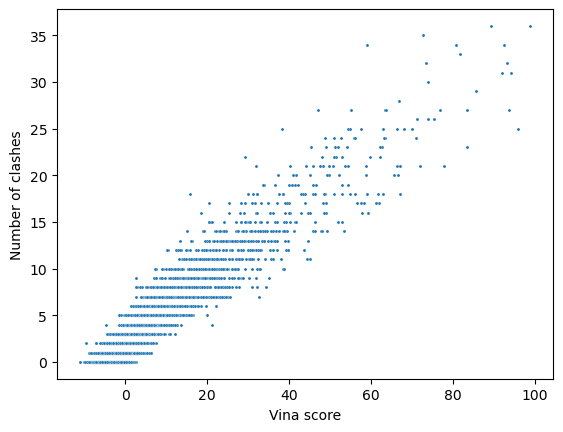

In [158]:
sns.scatterplot(data=sc_df[(~sc_df['Relaxed']) & (~sc_df['Valid only']) & (sc_df['Model'] == 'ResGen')],
               x='Vina score',
               y='Number of clashes',
               s=5)
plt.savefig('figures/vina_vs_clash.png', dpi=300, bbox_inches='tight')

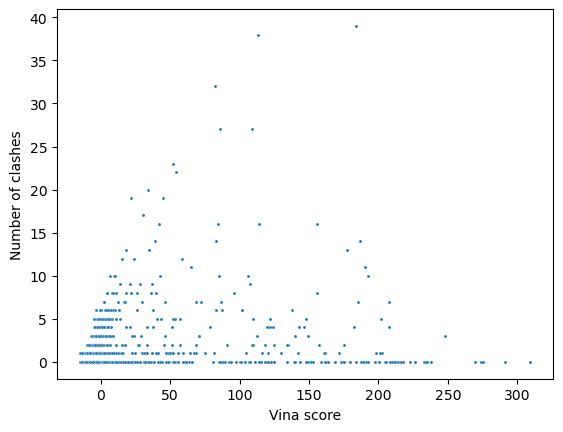

In [49]:
sns.scatterplot(data=sc_df[(~sc_df['Relaxed']) & (~sc_df['Valid only']) & (sc_df['Model'] == 'DiffSBDD')],
               x='Vina score',
               y='Number of clashes',
               s=5)
plt.savefig('figures/vina_vs_clash.png', dpi=300, bbox_inches='tight')

In [44]:
subset_df = sc_df[(~sc_df['Relaxed']) & (~sc_df['Valid only']) & (sc_df['Model'] == 'ResGen')]
r2_score(subset_df['Vina score'], subset_df['Number of clashes'])

0.5652375922583002

<Axes: xlabel='Vina score', ylabel='Number of clashes'>

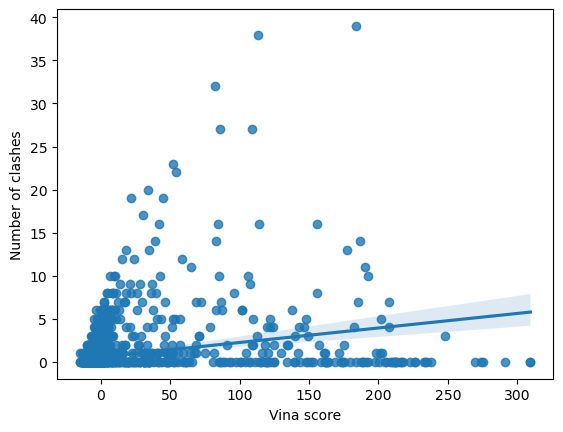

In [46]:
sns.regplot(data=sc_df[(~sc_df['Relaxed']) & (~sc_df['Valid only']) & (sc_df['Model'] == 'DiffSBDD')],
               x='Vina score',
               y='Number of clashes')

In [47]:
len(set_results['Vina score'])

40

In [48]:
len(sc_set_results['Steric clash'])

40

In [8]:
score_rows = []
for ligand_filename in test_crossdocked.get_ligand_filenames():
    all_model_tested = len(d_results[ligand_filename][False]) == len(models)
    all_mini_model_tested = len(d_results[ligand_filename][True]) == len(models)
    if all_model_tested and all_mini_model_tested:
        for minimize in minimizes:
            for model in models:
                model_results = d_results[ligand_filename][minimize][model.name]
                if minimize:
                    set_names = ['minimized', 'minimized_valid']
                    subset = 'Relaxed'
                else:
                    set_names = ['raw', 'raw_valid']
                    subset = 'Raw'
                for set_name in set_names:
                    set_results = model_results[set_name]
                    if 'Steric clash' in set_results:
                        assert len(set_results['Steric clash']) == len(set_results['Distance to native centroid'])
                        for sc, dtnc in zip(set_results['Steric clash'], set_results['Distance to native centroid']):
                            row = {'Model' : model.name,
                                  'Subset': subset,
                                  'Valid only': 'valid' in set_name,
                                  'Ligand filename': ligand_filename,
                                  'Steric clash': sc,
                                  'Distance to native centroid': dtnc}
                            score_rows.append(row)                  

In [30]:
score_df = pd.DataFrame(score_rows)
score_df['Model'] = score_df['Model'].replace('3D_SBDD', '3D-SBDD')
score_df['Model'] = pd.Categorical(score_df['Model'], model_names)

In [31]:
clash_colname = 'Fraction of generated molecules\nclashing with the pocket'
out_colname = 'Fraction of generated molecules\nout of the pocket'
score_df[clash_colname] = score_df['Steric clash'] > 0
score_df[out_colname] = score_df['Distance to native centroid'] > 10

In [32]:
noclash_colname = 'Fraction of generated molecules\nnot clashing with the pocket'
score_df[noclash_colname] = 1 - score_df[clash_colname]

In [33]:
grouped_score_df = score_df.groupby(['Model', 'Subset', 'Valid only', 'Ligand filename']).mean()
grouped_score_df = grouped_score_df.reset_index()
grouped_score_df = grouped_score_df.sort_values('Model')

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/indexes/multi.py:595: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/reshape/util.py:54: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [tile_compat(np.repeat(x, b[i]), np.product(a[i])) for i, x in enumerate(X)]
/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/algorithms.py:485: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


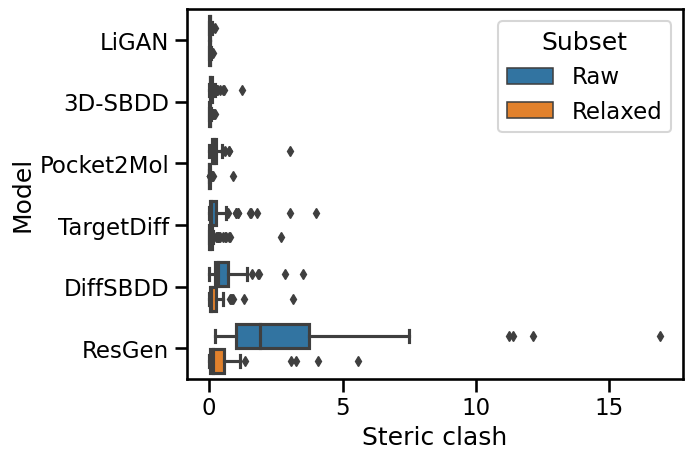

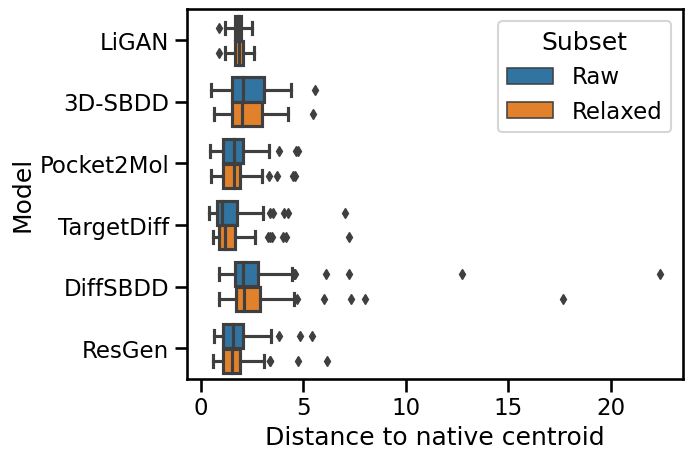

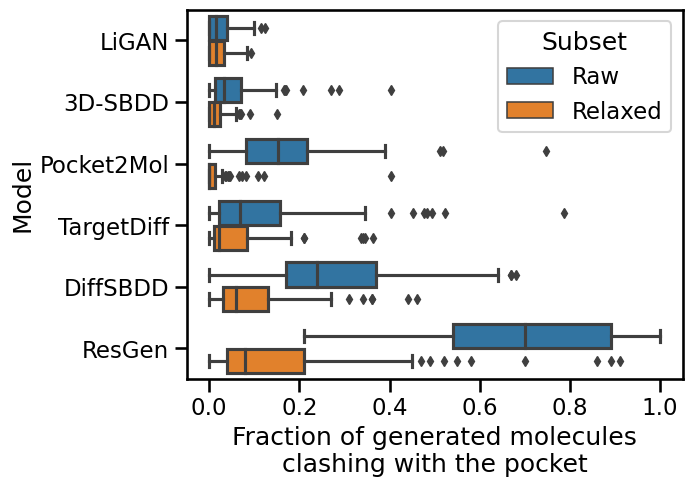

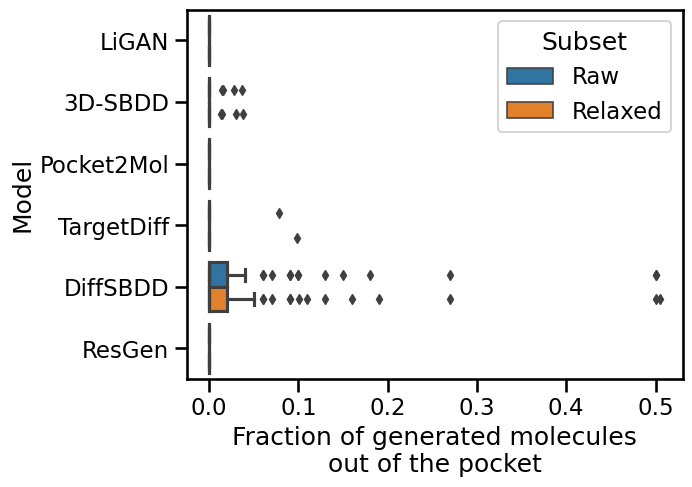

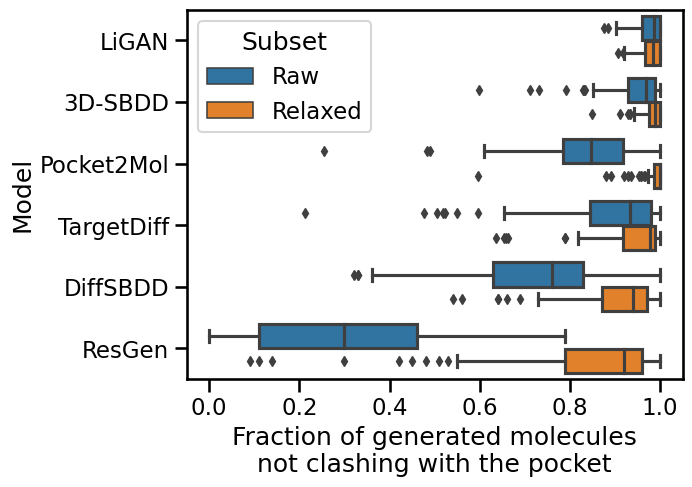

In [34]:
for column in grouped_score_df.columns[4:]:
    sns.boxplot(data=grouped_score_df[~grouped_score_df['Valid only']], x=column, hue='Subset', y='Model')
    plt.show()

In [35]:
grouped_score_df = score_df.groupby(['Model', 'Subset', 'Valid only']).mean()
grouped_score_df = grouped_score_df.reset_index()
grouped_score_df = grouped_score_df.sort_values('Model')

/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/indexes/multi.py:595: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/home/bb596/ssd/miniforge3/envs/csd/lib/python3.9/site-packages/pandas/core/reshape/util.py:54: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [tile_compat(np.repeat(x, b[i]), np.product(a[i])) for i, x in enumerate(X)]


In [42]:
grouped_score_df[~grouped_score_df['Valid only']][['Model', 'Subset', 'Distance to native centroid']]

,Model,Subset,Distance to native centroid
0,LiGAN,Raw,1.816004
2,LiGAN,Relaxed,1.833979
4,3D-SBDD,Raw,2.227579
6,3D-SBDD,Relaxed,2.229545
10,Pocket2Mol,Relaxed,1.670200
8,Pocket2Mol,Raw,1.701829
12,TargetDiff,Raw,1.424556
14,TargetDiff,Relaxed,1.480522
16,DiffSBDD,Raw,2.766277
18,DiffSBDD,Relaxed,2.662752


In [37]:
pastel_palette = sns.color_palette("pastel")
colorblind_palette = sns.color_palette("colorblind")

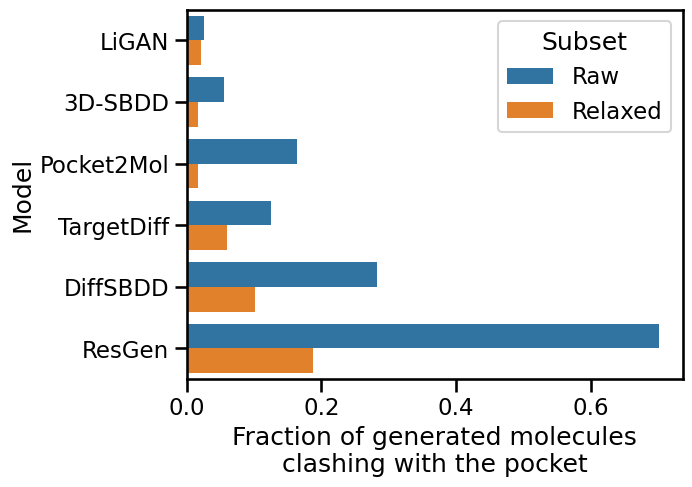

In [38]:
sns.barplot(data=grouped_score_df[~grouped_score_df['Valid only']], 
            x=clash_colname, 
            hue='Subset', 
            y='Model')
plt.savefig('figures/clash.png', dpi=300, bbox_inches='tight')

In [39]:
sns.set_palette('colorblind')
sns.set_context('talk')
hatches = ['', '//']

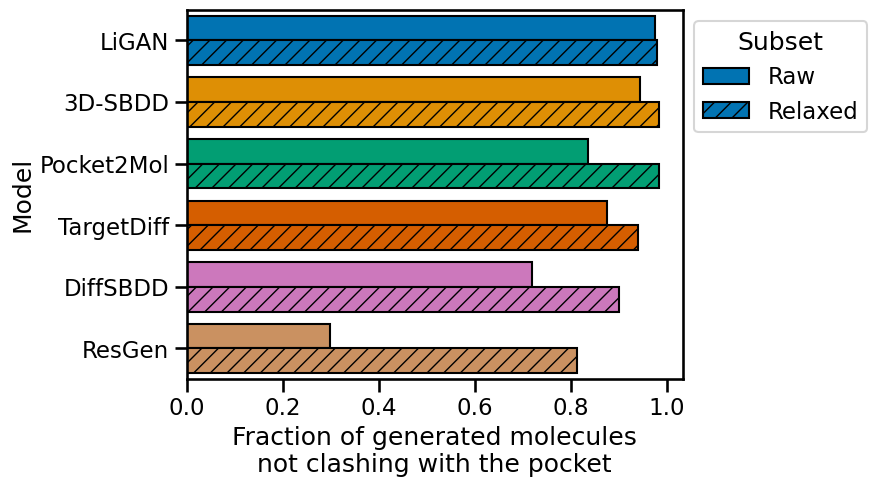

In [41]:
from matplotlib.legend_handler import HandlerTuple
ax = sns.barplot(data=grouped_score_df[~grouped_score_df['Valid only']], 
            x=noclash_colname, 
            hue='Subset', 
            y='Model',
                edgecolor='black')
for bars, colors, hatch in zip(ax.containers, (colorblind_palette, colorblind_palette), hatches):
    for bar, color in zip(bars, colors):
        bar.set_facecolor(color)
        bar.set_hatch(hatch)
ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), title='Subset')
# ax.legend(handles=[tuple(bar_group) for bar_group in ax.containers],
#           labels=[bar_group.get_label() for bar_group in ax.containers],
#           title=ax.legend_.get_title().get_text(),
#           handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0.1)},
#          loc="upper left", 
#               bbox_to_anchor=(1, 1))
plt.savefig('figures/noclash.png', dpi=300, bbox_inches='tight')